In [1]:
import polars as pl
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
class DataEngineering:
    def __init__(self, data):
        """
        Inicializa la clase con el DataFrame de Polars.
        :param data: DataFrame con los datos a procesar.
        """
        self.data = data

    def limpiar_fechas(self):
        """
        Normaliza y corrige los formatos de las columnas 'start_time' y 'end_time'.
        - Reemplaza '/' por '-' en las fechas.
        - Intenta parsear fechas en dos formatos: '%Y-%m-%d %H:%M:%S' y '%m-%d-%Y %H:%M'.
        """
        def unify_datetime_format(column):
            return column.str.replace_all("/", "-")

        # Reemplaza '/' por '-' en las fechas
        self.data = self.data.with_columns([
            unify_datetime_format(pl.col("start_time")).alias("start_time"),
            unify_datetime_format(pl.col("end_time")).alias("end_time")
        ])

        # Parseo de fechas con dos formatos posibles
        self.data = self.data.with_columns([
            pl.col("start_time")
            .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False)
            .alias("start_time_main"),
            pl.col("end_time")
            .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False)
            .alias("end_time_main"),
        ]).with_columns([
            # Maneja los nulos intentando otro formato
            pl.when(pl.col("start_time_main").is_null())
            .then(pl.col("start_time").str.strptime(pl.Datetime, format="%m-%d-%Y %H:%M", strict=False))
            .otherwise(pl.col("start_time_main")),
            pl.when(pl.col("end_time_main").is_null())
            .then(pl.col("end_time").str.strptime(pl.Datetime, format="%m-%d-%Y %H:%M", strict=False))
            .otherwise(pl.col("end_time_main"))
        ]).drop(["start_time_main", "end_time_main"])

    def calcular_distancia_km(self):
        """
        Calcula la distancia entre los puntos 'start_lat', 'start_lon' y 'end_lat', 'end_lon' en metros.
        """
        # Convierte las columnas de coordenadas a tipo float
        self.data = self.data.with_columns([
            pl.col("start_lat").cast(pl.Float64, strict=False),
            pl.col("start_lon").cast(pl.Float64, strict=False),
            pl.col("end_lat").cast(pl.Float64, strict=False),
            pl.col("end_lon").cast(pl.Float64, strict=False)
        ])

        try:
            self.data = self.data.filter(pl.col("passholder_type") != "NULL")     
        except:
            None
        # Conversión a GeoDataFrames y cálculo de distancia
        df_pd = self.data.to_pandas()
        gdf_start = gpd.GeoDataFrame(
            df_pd, geometry=gpd.points_from_xy(df_pd["start_lon"], df_pd["start_lat"]), crs="EPSG:4326"
        )
        gdf_end = gpd.GeoDataFrame(
            df_pd, geometry=gpd.points_from_xy(df_pd["end_lon"], df_pd["end_lat"]), crs="EPSG:4326"
        )

        # Convierte a metros y calcula distancia
        gdf_start, gdf_end = gdf_start.to_crs(epsg=3857), gdf_end.to_crs(epsg=3857)
        distancias_mts = round(gdf_start.geometry.distance(gdf_end.geometry), 1)

        # Agrega la distancia calculada al DataFrame
        self.data = self.data.with_columns(pl.Series(name="distancia_mts", values=distancias_mts))

    def agregar_franja_horaria(self):
        """
        Agrega la columna 'franja_horaria' según la hora de 'start_time'.
        """
        def categorizar_hora(hora):
            if 0 <= hora < 6:
                return "Madrugada"
            elif 6 <= hora < 12:
                return "Mañana"
            elif 12 <= hora < 18:
                return "Tarde"
            else:
                return "Noche"

        # Aplica la función para categorizar las horas
        self.data = self.data.with_columns(
            pl.col("start_time").dt.hour().map_elements(categorizar_hora, return_dtype=pl.String).alias("franja_horaria")
        )

    def agregar_estacion_del_ano(self):
        """
        Agrega la columna 'estacion_año' según el mes de 'start_time'.
        """
        def estacion_mes(mes):
            if mes in [12, 1, 2]:
                return "Invierno"
            elif mes in [3, 4, 5]:
                return "Primavera"
            elif mes in [6, 7, 8]:
                return "Verano"
            else:
                return "Otoño"

        # Aplica la función para determinar la estación
        self.data = self.data.with_columns(
            pl.col("start_time").dt.month().map_elements(estacion_mes, return_dtype=pl.String).alias("estacion_año")
        )

    def agregar_tiempo_promedio_estaciones(self):
        """
        Calcula y agrega el tiempo promedio de duración por estación y pares de estaciones.
        """
        # Tiempo promedio por estación de inicio
        duracion_promedio = (
            self.data.group_by("start_station")
            .agg(pl.col("duration").mean().alias("tiempo_promedio_estacion"))
        )
        self.data = self.data.join(duracion_promedio, on="start_station")

        # Tiempo promedio por pares de estaciones (inicio y fin)
        duracion_promedio_pares = (
            self.data.group_by(["start_station", "end_station"])
            .agg(pl.col("duration").mean().alias("tiempo_promedio_pares"))
        )
        self.data = self.data.join(duracion_promedio_pares, on=["start_station", "end_station"])

    def agregar_variables_adicionales(self):
        """
        Crea nuevas características adicionales para el análisis.
        - Día de la semana, hora de inicio.
        - Normalización de duración.
        - Velocidad promedio en metros por hora.
        - Indicador si la estación inicial y final son diferentes.
        - Frecuencia de viajes por día.
        - Duración promedio por tipo de usuario.
        - Frecuencia de uso de cada bicicleta.
        """
        # Extraer día y hora de inicio
        self.data = self.data.with_columns([
            pl.col("start_time").dt.weekday().alias("dia_semana"),
            pl.col("start_time").dt.hour().alias("hora_inicio")
        ])

        
        # Generar características adicionales
        self.data = self.data.with_columns([
            (pl.col("duration") / pl.col("duration").mean()).alias("duration_normalized"),
            (pl.col("distancia_mts") / (pl.col("duration") / 60)).alias("velocidad_promedio_mts"),
            (pl.col("start_station") != pl.col("end_station")).cast(pl.Int8).alias("diferente_estacion")
        ])

        # Frecuencia de viajes por día
        frecuencia_dia = (
            self.data.group_by("dia_semana")
            .agg(pl.len().alias("viajes_por_dia"))
        )
        self.data = self.data.join(frecuencia_dia, on="dia_semana")
    
        # Frecuencia de uso de cada bicicleta
        mediana_bike_id = self.data.select(pl.col("bike_id").median()).item() # Calcular la mediana de bike_id (ignorando nulos)
        
        # Rellenar nulos en 'bike_id' con la mediana
        self.data = self.data.with_columns(pl.col("bike_id").fill_null(mediana_bike_id))

        # Agrupación por 'bike_id'
        bike_usage = (
            self.data.group_by("bike_id")
            .agg(pl.len().alias("bike_usage"))
        )
        
        # Unión sin pérdida de filas
        self.data = self.data.join(bike_usage, on="bike_id", how="left")
                
        # Crear columnas 'año' y 'mes' a partir de 'start_time'
        self.data = self.data.with_columns([
            pl.col("start_time").dt.year().alias("year"),
            pl.col("start_time").dt.month().alias("month")
        ])
        
        # Calcular el promedio de plan_duration por 'año' y 'mes'
        if "plan_duration" in self.data.columns:
            promedio_plan_mes = (
                self.data
                .group_by(["year", "month"])
                .agg(pl.mean("plan_duration").alias("promedio_plan_duration_mes"))
            )
            
            self.data = self.data.join(promedio_plan_mes, on=["year", "month"])

            # Calcular el promedio de plan_duration por bike_id
            promedio_plan_por_bicicleta = (
                self.data
                .group_by("bike_id")
                .agg(pl.mean("plan_duration").alias("promedio_plan_duration_bicicleta"))
            )
            
            # Unir el promedio al DataFrame original
            self.data = self.data.join(promedio_plan_por_bicicleta, on="bike_id")
                        

    def ejecutar(self):
        """
        Ejecuta todas las transformaciones secuenciales.
        """
        self.limpiar_fechas()
        self.calcular_distancia_km()
        self.agregar_franja_horaria()
        self.agregar_estacion_del_ano()
        self.agregar_tiempo_promedio_estaciones()
        self.agregar_variables_adicionales()
        return self.data

In [3]:
# Cargar datos
train = pl.read_csv("./Data/train_set.csv", ignore_errors=True)
data_engineer = DataEngineering(train)
train=data_engineer.ejecutar()

# Calcular promedios en el conjunto de entrenamiento
promedios_train = (
    train.select(["year", "month", "plan_duration"])
    .group_by(["year", "month"])
    .agg(pl.mean("plan_duration").alias("promedio_plan_duration_mes"))
)

# Convertir a diccionario para facilitar el mapeo
promedios_dict = {
    (row["year"], row["month"]): row["promedio_plan_duration_mes"]
    for row in promedios_train.to_dicts()
}

# Calcular promedios en el conjunto de entrenamiento
promedios_bike_train = (
    train.select(["bike_id", "plan_duration"])
    .group_by("bike_id")
    .agg(pl.mean("plan_duration").alias("promedio_plan_duration_bicicleta"))
)

# Convertir a diccionario para facilitar el mapeo
promedios_bike_dict = {
    row["bike_id"]: row["promedio_plan_duration_bicicleta"]
    for row in promedios_bike_train.to_dicts()
}

In [4]:
test = pl.read_csv("./Data/test_set.csv", ignore_errors=True)
data_engineer = DataEngineering(test)
test=data_engineer.ejecutar()

# Crear función para asignar el promedio en el conjunto de prueba
def asignar_promedio(row):
    return promedios_dict.get((row["year"], row["month"]), None)

# Crear función para asignar el promedio en el conjunto de prueba
def asignar_promedio_bicicleta(row):
    return promedios_bike_dict.get(row["bike_id"], None)  # Retorna None si no se encuentra
    
# Aplicar el mapeo al conjunto de prueba usando map_elements
test = test.with_columns(
    pl.struct(["year", "month"])
    .map_elements(lambda x: promedios_dict.get((x["year"], x["month"]), None),pl.Float64)
    .alias("promedio_plan_duration_mes"),
    
    pl.col("bike_id")
    .map_elements(lambda x: promedios_bike_dict.get(x, None),pl.Float64)
    .alias("promedio_plan_duration_bicicleta")
)

In [5]:
# Ahora que ya extrajimos toda la información necesaria, podemos eliminar start_time y end_time
columns_delete = ["start_time", "end_time","trip_route_category","start_station","end_station","bike_id"]
test = test.drop(columns_delete)

test=test[["trip_id","duration", "franja_horaria", "tiempo_promedio_estacion", "distancia_mts", "estacion_año",
     "tiempo_promedio_pares","dia_semana","hora_inicio", "duration_normalized", "velocidad_promedio_mts",
     "diferente_estacion","viajes_por_dia","bike_usage",'year','month','promedio_plan_duration_mes','promedio_plan_duration_bicicleta']]

In [6]:
import pickle

# Cargar el pipeline
with open('./models/xgboost_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

# Cargar el LabelEncoder
with open('./models/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

    
# Realizar predicciones con el pipeline cargado
y_pred_numeric = loaded_pipeline.predict(test)

# Convertir las predicciones numéricas a etiquetas originales
y_pred_labels = label_encoder.inverse_transform(y_pred_numeric)

# Crear un DataFrame con trip_id y las predicciones en etiquetas originales
predicciones = test.select(["trip_id"]).with_columns(
    pl.Series(name="prediccion", values=y_pred_labels)
)

# Mostrar las primeras filas de las predicciones con etiquetas
print(predicciones.head())

# # Exportar las predicciones a un archivo CSV
predicciones.write_csv("predicciones_test_con_etiquetas.csv")
print("Predicciones exportadas exitosamente a 'predicciones_test_con_etiquetas.csv'")

C:\Users\jfgarcia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


shape: (5, 2)
┌──────────┬──────────────┐
│ trip_id  ┆ prediccion   │
│ ---      ┆ ---          │
│ i64      ┆ str          │
╞══════════╪══════════════╡
│ 17059130 ┆ Monthly Pass │
│ 17059129 ┆ Walk-up      │
│ 17059126 ┆ Walk-up      │
│ 17059125 ┆ Walk-up      │
│ 17061379 ┆ Walk-up      │
└──────────┴──────────────┘
Predicciones exportadas exitosamente a 'predicciones_test_con_etiquetas.csv'


Distribución de Predicciones:
          Clase  Frecuencia (%)  Cantidad
0  Monthly Pass       70.028216    399081
1       Walk-up       28.238455    160927
2  One Day Pass        1.027574      5856
3   Annual Pass        0.690314      3934
4     Flex Pass        0.015266        87
5       Testing        0.000175         1


C:\Users\jfgarcia\AppData\Local\Temp\ipykernel_17276\1568800862.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


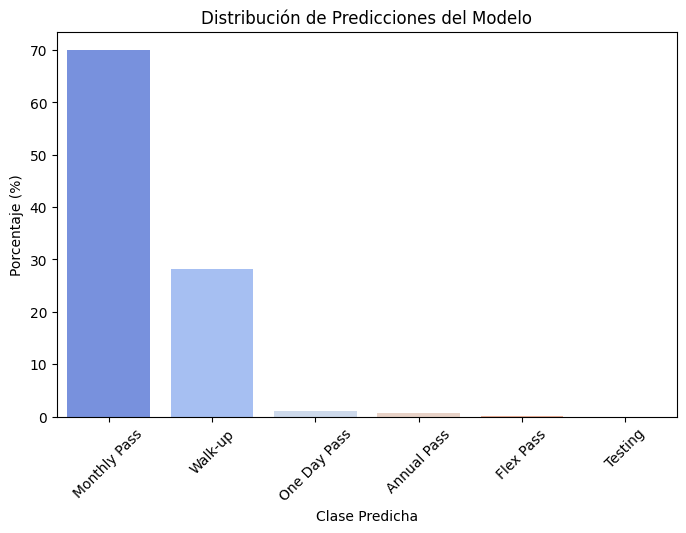

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame de Polars con las predicciones
predictions_data = test.select(["trip_id"]).with_columns(
    pl.Series(name="Predicted_Class", values=y_pred_labels)
)


# Calcular la distribución de las predicciones
predictions_distribution = (
    predictions_data.to_pandas()["Predicted_Class"]
    .value_counts(normalize=True) * 100
)
predictions_counts = (
    predictions_data.to_pandas()["Predicted_Class"]
    .value_counts()
)

# Crear un DataFrame para análisis de la distribución
predictions_df = pd.DataFrame({
    "Clase": predictions_distribution.index,
    "Frecuencia (%)": predictions_distribution.values,
    "Cantidad": predictions_counts.values
})

print("Distribución de Predicciones:")
print(predictions_df)

# Graficar la distribución de las predicciones
plt.figure(figsize=(8, 5))
sns.barplot(
    x=predictions_distribution.index,
    y=predictions_distribution.values,
    palette='coolwarm'
)
plt.title("Distribución de Predicciones del Modelo")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Clase Predicha")
plt.xticks(rotation=45)
plt.show()
